In [1]:
import matplotlib.pyplot as plt
import os
from firebolt.client.auth import UsernamePassword
from firebolt.db import connect
from firebolt.client import DEFAULT_API_URL
from datetime import datetime

engine_name = os.getenv("FIREBOLT_ENGINE")
database_name = os.getenv("FIREBOLT_DATABASE")
username = os.getenv("FIREBOLT_USER")
password = os.getenv("FIREBOLT_PASSWORD")

# create a connection based on provided credentials
connection = connect(
    auth=UsernamePassword(username, password),
    engine_name=engine_name,
    database=database_name,
)
    
# create a cursor for connection
cursor = connection.cursor()

connection.closed

False

In [2]:
cursor.execute("SELECT NOW();")

cursor.fetchone()

[datetime.datetime(2022, 12, 14, 16, 3, 21)]

In [3]:
count = cursor.execute("SELECT count(*) FROM gharchive;")

"{:,}".format(cursor.fetchone()[0])

'5,081,289,653'

In [4]:
cursor.execute("SELECT count(distinct(repo_name)) from gharchive;")
"Unique repos: {:,}".format(cursor.fetchone()[0])

'Unique repos: 267,049,947'

In [5]:
cursor.execute("SELECT count(distinct(actor_login)) from gharchive;")
"Unique users: {:,}".format(cursor.fetchone()[0])

'Unique users: 51,296,346'

In [6]:
cursor.execute("SELECT max(created_at), min(created_at) from gharchive;")
data = cursor.fetchone()
print(data[1])
print(data[0])

2015-01-01 00:00:00
2022-11-27 23:59:59


In [7]:
cursor.execute("""
SELECT EXTRACT(YEAR FROM created_at) as year, count(*) AS cnt 
FROM gharchive
GROUP BY year
ORDER BY year ASC;
""")

events_per_year = cursor.fetchall()

print(events_per_year)

[[2015, 212222000], [2016, 320732049], [2017, 412942962], [2018, 479212075], [2019, 605635078], [2020, 872478498], [2021, 1022177539], [2022, 1155889452]]


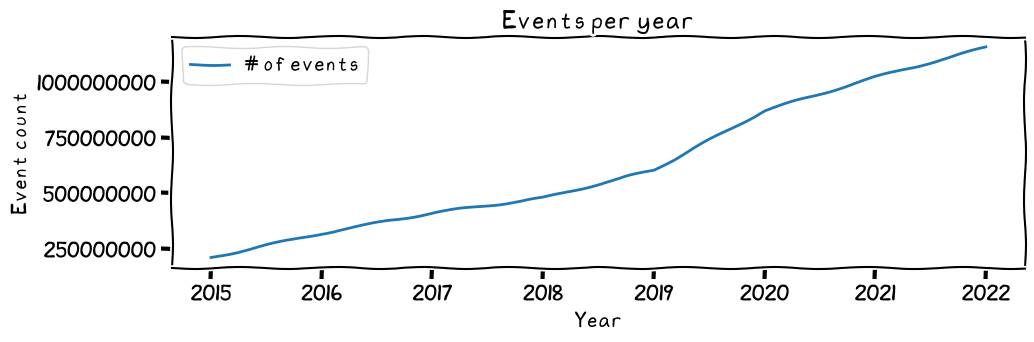

In [8]:
with plt.xkcd():
    plt.figure(figsize=(11,3))
    plt.plot([item[0] for item in events_per_year], [item[1] for item in events_per_year], label="# of events")
    plt.ticklabel_format(axis='both', style='plain')
    plt.xlabel('Year')
    plt.ylabel('Event count')
    plt.title('Events per year')
    plt.legend()
    plt.show()


In [9]:
cursor.execute("""
SELECT DATE_TRUNC('DAY', created_at) as day, count(*) as cnt
FROM gharchive
GROUP BY day
ORDER BY day
""")

all_events_per_day = cursor.fetchall()

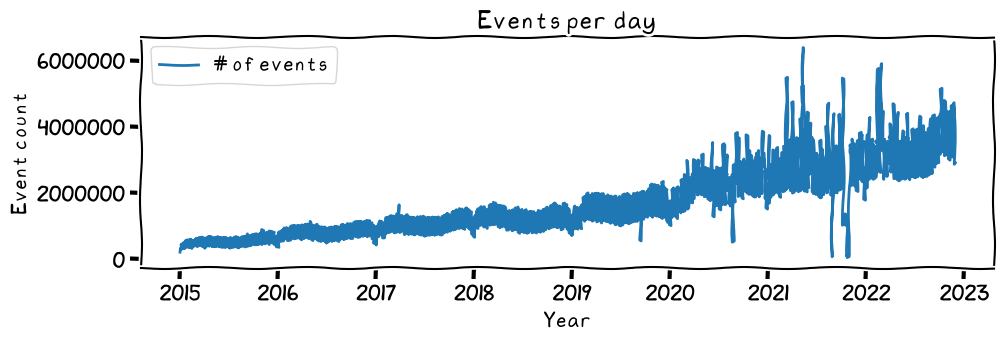

In [10]:
with plt.xkcd():
    plt.figure(figsize=(11,3))
    plt.plot([item[0] for item in all_events_per_day], [item[1] for item in all_events_per_day], label="# of events")
    plt.ticklabel_format(axis='y', style='plain')
    plt.xlabel('Year')
    plt.ylabel('Event count')
    plt.title('Events per day')
    plt.legend()
    plt.show()

In [11]:
cursor.execute("""
SELECT DATE_TRUNC('DAY', created_at) as day,
       count(*),
       AVG(count(*)) OVER (ORDER BY DATE_TRUNC('DAY', created_at) DESC ROWS BETWEEN 21 PRECEDING AND CURRENT ROW) as moving_average
FROM gharchive GROUP BY day ORDER BY day DESC;
""")

all_events_per_day_smoothed = cursor.fetchall()

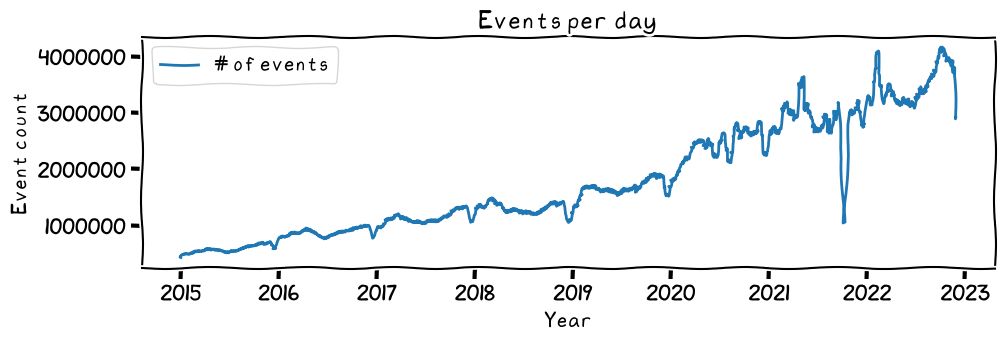

In [12]:
with plt.xkcd():
    plt.figure(figsize=(11,3))
    plt.plot([item[0] for item in all_events_per_day_smoothed], [item[2] for item in all_events_per_day_smoothed], label="# of events")
    plt.ticklabel_format(axis='y', style='plain')
    plt.xlabel('Year')
    plt.ylabel('Event count')
    plt.title('Events per day')
    plt.legend()
    plt.show()

In [13]:
cursor.execute("""
EXPLAIN
SELECT DATE_TRUNC('DAY', created_at) as day,
       count(*),
       AVG(count(*)) OVER (ORDER BY DATE_TRUNC('DAY', created_at) DESC ROWS BETWEEN 21 PRECEDING AND CURRENT ROW) as moving_average
FROM gharchive GROUP BY day ORDER BY day DESC;
""")

print(cursor.fetchone()[0])

[0] [Alias] FB_NODE_7.DATE_TRUNC('day',created_at) AS day, COUNT(FB_NODE_7.COUNT(*)) AS COUNT(*), AVG(TO_NULLABLE(COUNT(FB_NODE_7.COUNT(*)))) OVER (ORDER BY FB_NODE_7.DATE_TRUNC('day',created_at) Descending ROWS BETWEEN 21 PRECEDING AND CURRENT ROW) AS moving_average @ FB_NODE_1
 \_[1] [Sort] FB_NODE_7.DATE_TRUNC('day',created_at) (Descending) @ FB_NODE_2
    \_[2] [Window] Windows: [AVG(TO_NULLABLE(COUNT(FB_NODE_7.COUNT(*)))) OVER (ORDER BY FB_NODE_7.DATE_TRUNC('day',created_at) Descending ROWS BETWEEN 21 PRECEDING AND CURRENT ROW)] @ FB_NODE_3
       \_[3] [Projection] FB_NODE_7.DATE_TRUNC('day',created_at), COUNT(FB_NODE_7.COUNT(*)), TO_NULLABLE(COUNT(FB_NODE_7.COUNT(*))) @ FB_NODE_4
          \_[4] [Predicate] 0L < COUNT(FB_NODE_7.COUNT(*)) @ FB_NODE_5
             \_[5] [Aggregate] GroupBy: [FB_NODE_7.DATE_TRUNC('day',created_at)] Aggregates: [COUNT(FB_NODE_7.COUNT(*))] @ FB_NODE_6
                \_[6] [StoredTable] Name: 'gharchive_agg_streamlit_app_mainpage_count_date_filter__F

In [14]:
cursor.execute("SELECT * FROM information_schema.tables WHERE table_name='gharchive';") 

print(cursor.fetchall())

[['General_Demo_Datasets', 'public', 'gharchive', 'FACT', 'event_type, actor_login, repo_name', 5081289653, 1014126291331.0, 5630061365816.0, 5.6, 7145, None, None, None, None, None, None, None, None, 'gharchive_31fe66fe_bbcc_40ba_969a_23256b60adb5', 'Valid', 'CREATE FACT TABLE IF NOT EXISTS "gharchive" ("event_id" text NOT NULL, "event_type" text NOT NULL, "created_at" timestamp NOT NULL, "actor_id" long NOT NULL, "actor_login" text NOT NULL, "actor_display_login" text NOT NULL, "actor_gravatar_id" text NOT NULL, "actor_avatar_url" text NOT NULL, "repo_id" long NOT NULL, "repo_name" text NOT NULL, "org_id" long NULL, "org_login" text NULL, "org_gravatar_id" text NULL, "org_avatar_url" text NULL, "action" text NULL, "html_url" text NULL, "labels" array(text NOT NULL) NOT NULL, "assignees" array(text NOT NULL) NOT NULL, "title" text NULL, "body" text NULL, "milestone" text NULL, "draft" boolean NULL, "payload_user_login" text NULL, "payload_user_type" text NULL, "payload_user_id" long N

In [15]:
cursor.execute("""
SELECT * FROM information_schema.indexes
WHERE table_name='gharchive' AND index_name='gharchive_agg_streamlit_app_mainpage_count_date_filter';
""")
indexes = cursor.fetchall()

print(indexes, '\n')

print(indexes[0][5])

[['General_Demo_Datasets', 'public', 'gharchive', 'gharchive_agg_streamlit_app_mainpage_count_date_filter', 'aggregating', '[DATE_TRUNC(\'day\', "created_at"),EXTRACT(YEAR FROM "created_at"),EXTRACT(MONTH FROM "created_at"),COUNT(*),APPROX_COUNT_DISTINCT("repo_name"),APPROX_COUNT_DISTINCT("actor_login")]', 3331415773, 5686201530, 1274]] 

[DATE_TRUNC('day', "created_at"),EXTRACT(YEAR FROM "created_at"),EXTRACT(MONTH FROM "created_at"),COUNT(*),APPROX_COUNT_DISTINCT("repo_name"),APPROX_COUNT_DISTINCT("actor_login")]


In [16]:
cursor.execute("SELECT distinct(index_type) FROM information_schema.indexes WHERE table_name='gharchive' ")
print(cursor.fetchall())

[['primary'], ['aggregating']]


In [17]:
# clean up
connection.close()

connection.closed

True